In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (20.0, 10.0)

### data set reading

In [2]:
df = pd.read_csv('c:/users/arkaj/desktop/AAPL - yfinance.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,14.621429,14.732143,14.607143,14.686786,12.519276,302220800
1,2012-01-04,14.642857,14.810000,14.617143,14.765714,12.586555,260022000
2,2012-01-05,14.819643,14.948214,14.738214,14.929643,12.726293,271269600
3,2012-01-06,14.991786,15.098214,14.972143,15.085714,12.859333,318292800
4,2012-01-09,15.196429,15.276786,15.048214,15.061786,12.838935,394024400


### preprocessing data set to perform analysis

In [3]:
df.shape

(2742, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2742 entries, 0 to 2741
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2742 non-null   object 
 1   Open       2742 non-null   float64
 2   High       2742 non-null   float64
 3   Low        2742 non-null   float64
 4   Close      2742 non-null   float64
 5   Adj Close  2742 non-null   float64
 6   Volume     2742 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 150.1+ KB


In [5]:
df1 = df.iloc[:,1]
df1.head()

0    14.621429
1    14.642857
2    14.819643
3    14.991786
4    15.196429
Name: Open, dtype: float64

In [6]:
df1.tail()

2737    149.130005
2738    146.429993
2739    152.309998
2740    150.160004
2741    148.130005
Name: Open, dtype: float64

In [7]:
df1 = df1.replace('[\$,]', '', regex=True).astype(float)
df1.head()

0    14.621429
1    14.642857
2    14.819643
3    14.991786
4    15.196429
Name: Open, dtype: float64

Text(0, 0.5, 'stock price')

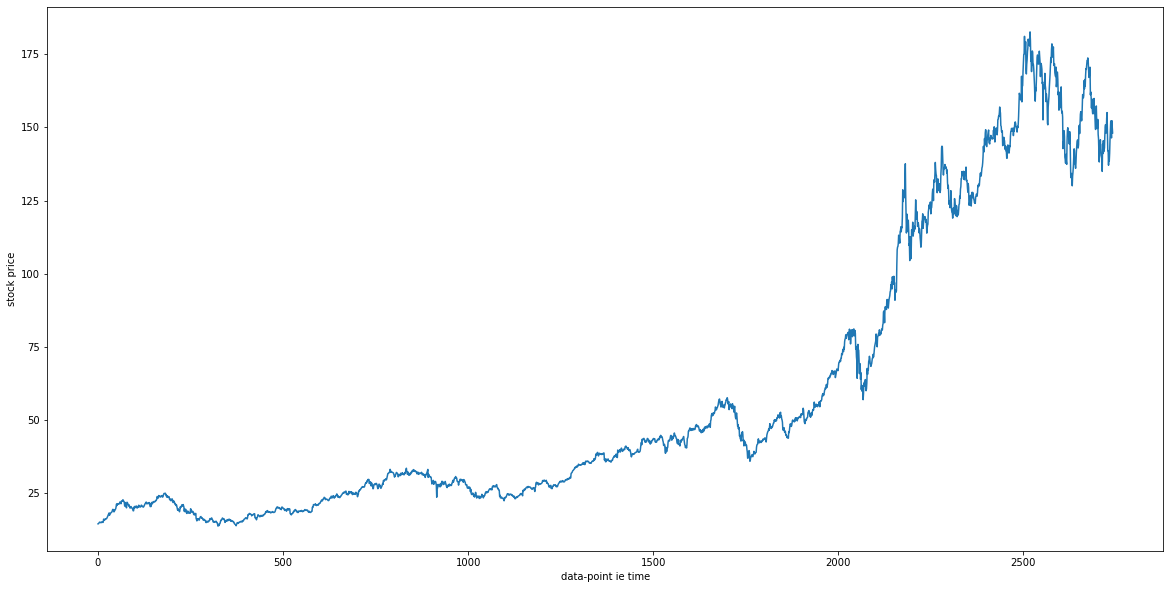

In [8]:
plt.plot(df1)
plt.xlabel("data-point ie time")
plt.ylabel("stock price")

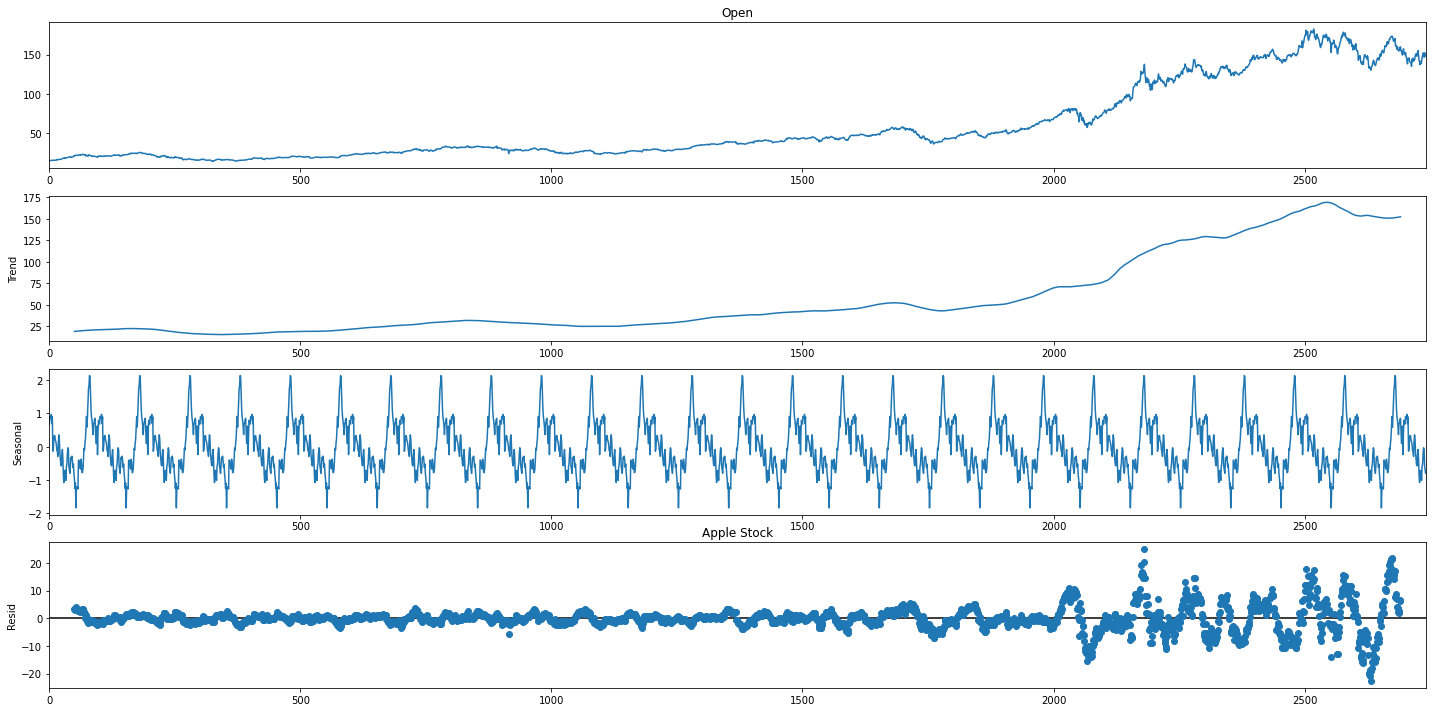

In [9]:
#show the components of this time series
from statsmodels.tsa.seasonal import seasonal_decompose

result  = seasonal_decompose(pd.Series(df1),period=100)

result.plot()
plt.title('Apple Stock')
plt.show()

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))

In [11]:
df1.shape

(2742,)

In [12]:
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [13]:
print(df1)
print('\n df1 present shape : ', df1.shape)

[[0.00453481]
 [0.00466177]
 [0.00570925]
 ...
 [0.82035136]
 [0.80761247]
 [0.79558455]]

 df1 present shape :  (2742, 1)


### splitting data (70/30)

In [14]:
training_size = int(len(df1)*0.7)
test_size = len(df1) - training_size
print('Training Size : ',training_size)
print('Test Size : ',test_size)

Training Size :  1919
Test Size :  823


In [15]:
train_data, test_data = df1[0:training_size,:],df1[training_size:len(df1),:]
print('Training Data Shape : ', train_data.shape)
print('Test Data Shape: ', test_data.shape)

Training Data Shape :  (1919, 1)
Test Data Shape:  (823, 1)


### | windowing data set |

In [16]:
def create_dataset(dataset, window=1):
    dataX, dataY= [], []
    for i in range(len(dataset)-window-1):
        a = dataset[i:(i+window),0]
        dataX.append(a)
        dataY.append(dataset[i+window,0])
    return np.array(dataX), np.array(dataY)

In [17]:
window = 100
X_train, y_train = create_dataset(train_data, window=100)
X_test, y_test = create_dataset(test_data, window=100)

In [18]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1818, 100) (1818,)
(722, 100) (722,)


In [19]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

### lstm coding

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [21]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer = 'adam')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


### fitting data to model

In [23]:
model.fit(X_train,y_train,validation_data = (X_test,y_test), epochs = 100, batch_size=64,verbose=1)

Epoch 1/100
29/29 [==============================] - 9s 162ms/step - loss: 0.0017 - val_loss: 0.0027
Epoch 2/100
29/29 [==============================] - 4s 146ms/step - loss: 1.3098e-04 - val_loss: 0.0057
Epoch 3/100
29/29 [==============================] - 4s 122ms/step - loss: 8.5601e-05 - val_loss: 0.0051
Epoch 4/100
29/29 [==============================] - 4s 126ms/step - loss: 8.3161e-05 - val_loss: 0.0059
Epoch 5/100
29/29 [==============================] - 4s 122ms/step - loss: 7.9845e-05 - val_loss: 0.0074
Epoch 6/100
29/29 [==============================] - 4s 125ms/step - loss: 7.7121e-05 - val_loss: 0.0083
Epoch 7/100
29/29 [==============================] - 4s 125ms/step - loss: 7.1822e-05 - val_loss: 0.0103
Epoch 8/100
29/29 [==============================] - 4s 124ms/step - loss: 7.2024e-05 - val_loss: 0.0070
Epoch 9/100
29/29 [==============================] - 4s 123ms/step - loss: 6.9019e-05 - val_loss: 0.0062
Epoch 10/100
29/29 [==============================] - 4s 12

29/29 [==============================] - 3s 116ms/step - loss: 2.1101e-05 - val_loss: 0.0081
Epoch 79/100
29/29 [==============================] - 3s 116ms/step - loss: 2.2332e-05 - val_loss: 0.0092
Epoch 80/100
29/29 [==============================] - 3s 116ms/step - loss: 2.1721e-05 - val_loss: 0.0070
Epoch 81/100
29/29 [==============================] - 3s 118ms/step - loss: 2.4072e-05 - val_loss: 0.0066
Epoch 82/100
29/29 [==============================] - 3s 117ms/step - loss: 2.1229e-05 - val_loss: 0.0061
Epoch 83/100
29/29 [==============================] - 3s 118ms/step - loss: 2.2744e-05 - val_loss: 0.0077
Epoch 84/100
29/29 [==============================] - 3s 118ms/step - loss: 2.2953e-05 - val_loss: 0.0085
Epoch 85/100
29/29 [==============================] - 3s 119ms/step - loss: 1.9818e-05 - val_loss: 0.0103
Epoch 86/100
29/29 [==============================] - 3s 120ms/step - loss: 2.3810e-05 - val_loss: 0.0078
Epoch 87/100
29/29 [==============================] - 3s 11

In [24]:
y_pred = scaler.inverse_transform(model.predict(X_test))

23/23 [==============================] - 1s 25ms/step


In [25]:
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [26]:
y_pred[:5]

array([[76.03107 ],
       [77.18851 ],
       [78.282005],
       [78.50544 ],
       [78.23827 ]], dtype=float32)

In [27]:
y_test[:5]

array([[77.910004],
       [79.175003],
       [77.962502],
       [78.397499],
       [79.067497]])

### evaluation

In [28]:
import math
from sklearn.metrics import mean_squared_error

rmse_score = math.sqrt(mean_squared_error(y_test,y_pred))
print('Root Mean Squared Error(test) : ',rmse_score)

Root Mean Squared Error(test) :  14.58384911959329


In [29]:
from sklearn.metrics import r2_score
print('R-squared Score  : ',r2_score(y_test,y_pred))

R-squared Score  :  0.7746127701936295


### visualization + plotting

57/57 [==============================] - 1s 24ms/step


No handles with labels found to put in legend.


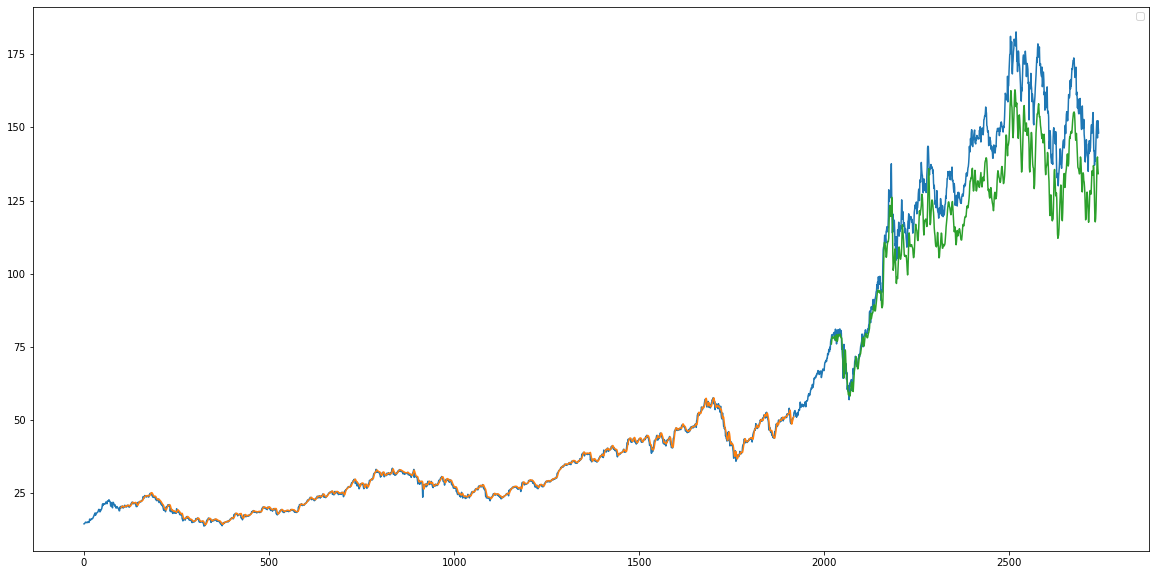

In [30]:
# shift train predictions for plotting
train_predict = scaler.inverse_transform(model.predict(X_train))

look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = y_pred
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend()
plt.show()

### predicting 30 Days future value

In [31]:
x_input=test_data[len(test_data)-100:].reshape(1,-1)
x_input.shape

(1, 100)

In [32]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [33]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        #print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        #print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

#print(lst_output)

In [34]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [35]:
print(scaler.inverse_transform(lst_output))

[[131.29577572]
 [121.52581517]
 [106.9657324 ]
 [ 89.95479232]
 [ 71.96363909]
 [ 54.35724212]
 [ 38.49081289]
 [ 25.39484551]
 [ 15.47806789]
 [  8.53390074]
 [  3.99530522]
 [  1.20620776]
 [ -0.41921132]
 [ -1.34097001]
 [ -1.89214028]
 [ -2.29670285]
 [ -2.69080709]
 [ -3.14302126]
 [ -3.67278321]
 [ -4.26697761]
 [ -4.89426845]
 [ -5.51665267]
 [ -6.09785621]
 [ -6.6086204 ]
 [ -7.02916157]
 [ -7.34959729]
 [ -7.56884365]
 [ -7.69277928]
 [ -7.73216305]
 [ -7.7005152 ]]


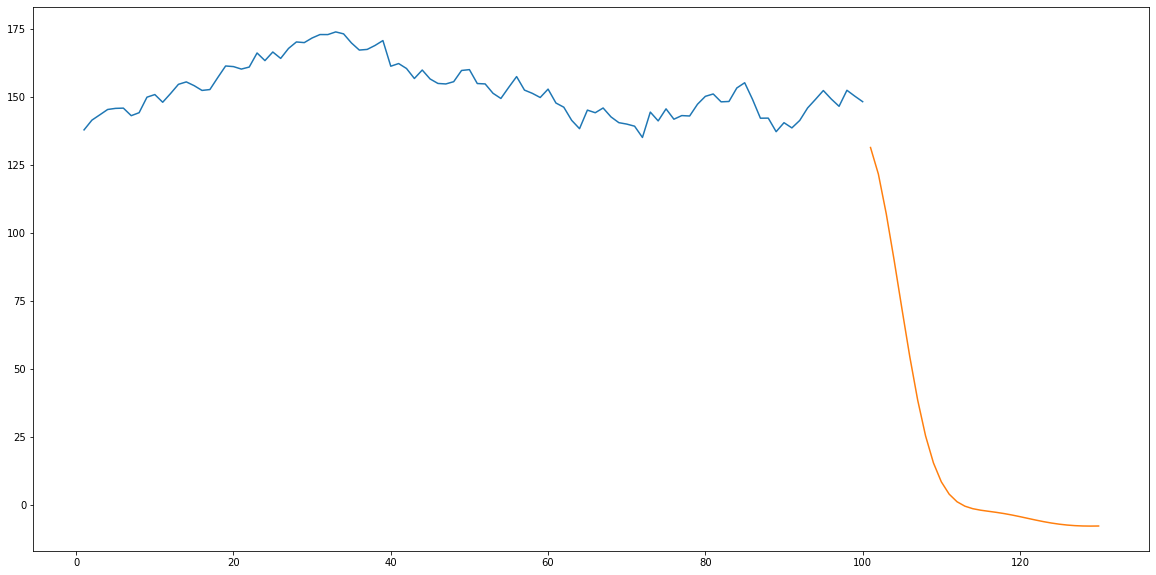

In [36]:
plt.plot(day_new,scaler.inverse_transform(df1[len(df1)-100:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))